In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import scipy.stats
import numpy as np

import diffxpy.api as de

# Generate some data:

In [2]:
from batchglm.api.models.glm_nb import Simulator

sim = Simulator(num_observations=2000, num_features=100)
sim.generate_sample_description(num_batches=4, num_conditions=0)
sim.generate_params()
sim.generate_data()

# Run differential expression test:

The pairwise test allows to perform pairwise comparisons between a set of groups.

It needs a parameter `grouping` which assigns a group to each sample.
This `grouping` can either be a vector of length `num_observations` or a string specifying a column in the sample description.
Since we simulated `grouping` with `num_batches=4` different groups, the pairwise test will perform $\frac{n*(n-1)}{2} = 6$ different tests.

The parameter `test` specifies which kind of statistical test will be performed for each pair of groups.
Possible arguments are all `two_sample` tests (e.g. 'wald', 't-test', 'wilcoxon', ...) and 'z-test'.
The 'z-test' is a special kind of test which treats each group as a coefficient in a single linear model and therefore requires fitting only one GLM for all tests. This significantly reduces the runtime compared to the 'wald'-test.

In [3]:
logging.getLogger("tensorflow").setLevel(logging.ERROR)
logging.getLogger("batchglm").setLevel(logging.INFO)
logging.getLogger("diffxpy").setLevel(logging.INFO)

test = de.test.pairwise(
    data=sim.X,
    grouping="batch",
    test="z-test",
    noise_model="nb",
    sample_description=sim.sample_description,
    batch_size=100,
    training_strategy="DEFAULT",
    dtype="float64"
)

INFO:diffxpy.testing.base:Fitting model...


/Users/david.fischer/miniconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/Users/david.fischer/miniconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/Users/david.fischer/miniconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/Users/david.fischer/miniconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)


# Obtaining the results

## Global results across all tests

The p-/q-values can be obtained by calling `test.pval` / `test.qval`:

In [4]:
np.set_printoptions(precision=3)
print("shape of p-values: %s" % str(test.pval.shape))

shape of p-values: (4, 4, 100)


In [5]:
test.pval[:,:,0]

array([[1.000e+00, 0.000e+00, 0.000e+00, 3.129e-09],
       [0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00],
       [0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00],
       [3.129e-09, 0.000e+00, 0.000e+00, 1.000e+00]])

p-values of first gene:

In [6]:
test.summary().iloc[:10,:]

,gene,pval,qval,log2fc,mean
0,0,0.000000e+00,0.000000e+00,1.846952,658.0360
1,1,0.000000e+00,0.000000e+00,-1.825088,682.0765
2,2,0.000000e+00,0.000000e+00,-1.646235,452.2620
3,3,0.000000e+00,0.000000e+00,0.885091,438.0975
4,4,0.000000e+00,0.000000e+00,-1.959003,489.3750
5,5,0.000000e+00,0.000000e+00,1.240108,697.9060
6,6,5.462297e-14,1.655242e-13,1.079650,661.9420
7,7,0.000000e+00,0.000000e+00,-1.327794,483.5920
8,8,7.416060e-06,1.464901e-05,0.380631,611.8240
9,9,0.000000e+00,0.000000e+00,-1.403804,587.4850


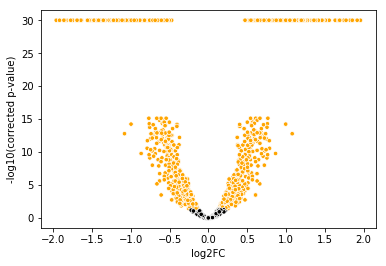

In [7]:
test.plot_volcano()

test.summary() returns a pandas DataFrame with a quick overview of the test results:

## Results specific for one test

- `gene`: gene name / identifier
- `pval`: minimal p-value of the tests
- `qval`: minimal multiple testing - corrected p-value of the tests
- `log2fc`: maximal $log_2$ fold change of the tests

`test.plot_volcano()` creates a volcano plot of p-values vs. fold-change:

One may be specifically interested in a the comparison of a specific pair of groups. Multiple methods presented above are adapated for this scenario and are simply called test.*_groups

The group identifiers are:

In [9]:
print(np.unique(sim.sample_description['batch'].values))

['0' '1' '2' '3']


The results for the comparison of groups '2' and '3' are:

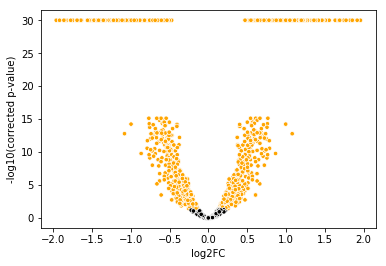

In [10]:
test.plot_diagnostics()

In [11]:
test.pval_pair(group1='2', group2='3')[:10]

array([0.000e+00, 0.000e+00, 0.000e+00, 2.417e-03, 0.000e+00, 3.308e-01,
       1.828e-04, 0.000e+00, 7.669e-01, 0.000e+00])

In [12]:
test.summary_pair(group1='2', group2='3').iloc[:10,:]

,gene,pval,qval,log2fc,mean
0,0,0.000000,4.940656e-324,-0.661575,658.0360
1,1,0.000000,4.940656e-324,1.476488,682.0765
2,2,0.000000,4.940656e-324,0.605507,452.2620
3,3,0.002417,4.061579e-03,-0.220605,438.0975
4,4,0.000000,4.940656e-324,-1.959003,489.3750
5,5,0.330787,4.700343e-01,0.107754,697.9060
6,6,0.000183,3.307706e-04,-0.607632,661.9420
7,7,0.000000,4.940656e-324,1.056921,483.5920
8,8,0.766882,1.000000e+00,0.029352,611.8240
9,9,0.000000,4.940656e-324,-1.403804,587.4850
